In [1]:
# IMPORT SECTION
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import ipaddress
from ipaddress import ip_network
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
# path to the version 1.0 of the provided data
version10 = "output_ml_students.zip"  
# path to the version 1.1 of the provided data
version11 = "output_ml_students_twosets.zip"
# path to the version 1.2 of the provided data
version12 = "output_ml_students_swiss_update.zip"

def my_read_fn(label):
    mapping = {
        "backend_prop": (version10, "backend_assetproperty.csv"),
        "backend_relservicemetric": (version10, "backend_assetrelationshipservicemetric.csv"),  
        "backend_relservices": (version10,"backend_assetrelationshipservice.csv"),
        "backend_relations": (version10,"backend_assetrelationship.csv"),
        "backend_types": (version10,"backend_assettype.csv"),
        "backend_asset": (version10,"backend_asset.csv"),
        "swiss_prop": (version11, "swisstools_asset_properties.csv"),
        "swiss_relservice_metrics": (version11, "swisstools_asset_relationship_service_metrics.csv"),
        "swiss_relservices": (version11, "swisstools_asset_relationship_services.csv"),
        "swiss_relations": (version11, "swisstools_asset_relationships.csv"),
        "swiss_types": (version11, "swisstools_asset_types.csv"),
        "swiss_asset": (version11, "swisstools_assets.csv"),
        "prop": (version12, "backend_assetproperty.csv"),
        "relservicemetric": (version12, "backend_assetrelationshipservicemetric.csv"),  
        "relservices": (version12,"backend_assetrelationshipservice.csv"),
        "relations": (version12,"backend_assetrelationship.csv"),
        "types": (version12,"backend_assettype.csv"),
        "asset": (version12,"backend_asset.csv"),
    }

    arch, filename = mapping[label]

    with zipfile.ZipFile(arch, 'r') as z:
        file_list = z.namelist()
        def find_file(target):
            return next((f for f in file_list if f.endswith(target)), None)

        file_in_zip = find_file(filename)
        if not file_in_zip:
            raise FileNotFoundError(f"{filename} not found in {arch}")

        return pd.read_csv(z.open(file_in_zip), low_memory=False)

backend_prop = my_read_fn("backend_prop")
backend_relservicemetric = my_read_fn("backend_relservicemetric")
backend_relservices = my_read_fn("backend_relservices")
backend_relations = my_read_fn("backend_relations")
backend_types = my_read_fn("backend_types")
backend_asset = my_read_fn("backend_asset")
swiss_prop = my_read_fn("swiss_prop")
swiss_relservice_metrics = my_read_fn("swiss_relservice_metrics")
swiss_relservices = my_read_fn("swiss_relservices")
swiss_relations = my_read_fn("swiss_relations")
swiss_types = my_read_fn("swiss_types")
swiss_asset = my_read_fn("swiss_asset")
prop = my_read_fn("prop")
relservicemetric = my_read_fn("relservicemetric")
relservices = my_read_fn("relservices")
relations = my_read_fn("relations")
types = my_read_fn("types")
asset = my_read_fn('asset')

In [3]:
def network_to_int(ip):
        """
        Convert IP address string to an integer.

        Parameters:
            ip (str): The IP address in string format (e.g., '192.168.1.0/24').

        Returns:
            int or None: The integer representation of the network address, or None if conversion fails.
        """
        try:
            return int(ip_network(ip, strict=False).network_address)
        except:
            return None

def mac_to_int(mac):
        """
        Convert MAC address to an integer by removing delimiters.

        Parameters:
            mac (str): The MAC address in string format (e.g., '00:1A:2B:3C:4D:5E' or '00-1A-2B-3C-4D-5E').

        Returns:
            int or None: The integer representation of the MAC address, or None if conversion fails.
    
        """
        try:
            return int(mac.replace(":", "").replace("-", "").lower(), 16)
        except:
            return None
def extract_first_vlan(vlan_str):
        """
        Extract the first VLAN ID from a string of comma-separated VLANs.
        
        Parameters:
            vlan_str (str): A string representing VLAN IDs (e.g., {2011}, or '{100,200,300}').

        Returns:
            int or None: The first VLAN ID as an integer, 0 if input is empty, or None if extraction fails.
        """
        
        try:
            if pd.isna(vlan_str) or vlan_str.strip('{}').strip() == '':
                return 0
            return int(vlan_str.strip('{}').split(',')[0].strip())
        except:
            return None
label_encoder = LabelEncoder()
# Drop unnecessary columns from Swiss asset dataset
swiss_asset=swiss_asset.drop(columns=['name','hostname','active','location_id','assigned_value','estimated_value'])
# Remove rows with missing asset_type_id (critical for joins)
swiss_asset = swiss_asset.dropna(subset=['asset_type_id'])
# Map 'processing_state' to a binary flag
swiss_asset['processing_state_binary'] = swiss_asset['processing_state'].map({
    'QUEUED': 1,
    'PROCESSED': 0
})
swiss_asset=swiss_asset.drop(columns=['processing_state'])
# Convert IP/MAC/VLAN features to integers
swiss_asset['ipaddress'] = swiss_asset['ipaddress'].apply(network_to_int)
swiss_asset['mac_address'] = swiss_asset['mac_address'].apply(mac_to_int)
swiss_asset['vlan_ids'] = swiss_asset['vlan_ids'].apply(extract_first_vlan)
# Calculate device age
swiss_asset['date_created'] = pd.to_datetime(swiss_asset['date_created'],utc=True).dt.tz_convert('UTC')
swiss_asset['date_updated'] = pd.to_datetime(swiss_asset['date_updated'],utc=True).dt.tz_convert('UTC')
swiss_asset['device_age_days'] = (swiss_asset['date_updated'] - swiss_asset['date_created']).dt.days
swiss_asset = swiss_asset.drop(columns=['date_created','date_updated','last_reported'])
swiss_types = swiss_types.dropna(subset='category')
swiss_types = swiss_types.drop(columns=['name','description','active','parent_asset_type_id','match_slug','icon','date_created','date_updated'])
# Clean and encode properties
swiss_prop['key'] = swiss_prop['key'].str.replace('^snmp_', '', regex=True)
swiss_prop['key'] = swiss_prop['key'].str.split('.').apply(lambda x: [int(i) for i in x if i != ''])
swiss_prop['key'] = swiss_prop['key'].apply(lambda x: int(''.join(map(str, x))))
swiss_prop["value"] = swiss_prop["value"].map(swiss_prop["value"].value_counts())
swiss_prop = swiss_prop.drop(columns=['date_created','date_updated','display_name'])
swiss_relations = swiss_relations.drop(columns=['id','date_created','date_updated','tags'])
swiss_relservices = swiss_relservices.drop(columns=['date_created','date_updated'])
swiss_relservice_metrics=swiss_relservice_metrics.drop(columns=['key','attributes','date_created','date_updated'])
# The same preprocessing was applied to Backend Dataset
backend_asset=backend_asset.drop(columns=['name','hostname','active','location_id','assigned_value','estimated_value'])
backend_asset = backend_asset.dropna(subset=['asset_type_id'])
backend_asset['processing_state_binary'] = backend_asset['processing_state'].map({
    'QUEUED': 1,
    'PROCESSED': 0
})
backend_asset=backend_asset.drop(columns=['processing_state'])
backend_asset['ipaddress'] = backend_asset['ipaddress'].apply(network_to_int)
backend_asset['mac_address'] = backend_asset['mac_address'].apply(mac_to_int)
backend_asset['vlan_ids'] = backend_asset['vlan_ids'].apply(extract_first_vlan)
backend_asset['date_created'] = pd.to_datetime(backend_asset['date_created'],utc=True).dt.tz_convert('UTC')
backend_asset['date_updated'] = pd.to_datetime(backend_asset['date_updated'],utc=True).dt.tz_convert('UTC')
backend_asset['device_age_days'] = (backend_asset['date_updated'] - backend_asset['date_created']).dt.days
backend_asset.drop(columns=['date_created','date_updated','last_reported'])
backend_types = backend_types.dropna(subset='category')
backend_types = backend_types.drop(columns=['name','description','active','parent_asset_type_id','match_slug','icon','date_created','date_updated'])
backend_prop['key'] = 0
backend_prop["value"] = backend_prop["value"].map(backend_prop["value"].value_counts())
backend_prop = backend_prop.drop(columns=['date_created','date_updated','display_name'])
backend_relations = backend_relations.drop(columns=['id','date_created','date_updated','tags'])
backend_relservices = backend_relservices.drop(columns=['date_created','date_updated'])
backend_relservicemetric = backend_relservicemetric.drop(columns=['key','attributes','date_created','date_updated'])
# MERGING SWISS NETWORK DATA
df = swiss_asset.merge(swiss_types, how='left', left_on='asset_type_id', right_on='id', suffixes=('', '_type'))
df = df.drop(columns=['id_type'])
df = df.merge(swiss_prop, how='left', left_on='id', right_on='asset_id', suffixes=('', '_prop'))
df['value'] = df['value'].fillna(0)
source_counts = swiss_relations['source_asset_id'].value_counts().rename('source_count')
target_counts = swiss_relations['target_asset_id'].value_counts().rename('target_count')
df['source_count'] =df['id'].map(source_counts).fillna(0).astype(int)
df['target_count'] =df['id'].map(target_counts).fillna(0).astype(int)
df = df.drop(columns=['asset_id','id_prop'])
child_counts = df['parent_asset_id'].value_counts().rename('child_count')
df['child_count'] = df['id'].map(child_counts).fillna(0).astype(int)
df['has_parent'] = df['parent_asset_id'].notna().astype(int)
vendor_counts = df['vendor'].value_counts()
df['vendor'] = df['vendor'].map(vendor_counts)
# MERGING BACKEND NETWORK DATA
dff = backend_asset.merge(backend_types, how='left', left_on='asset_type_id', right_on='id', suffixes=('', '_type'))
dff = dff.drop(columns=['id_type'])
dff = dff.merge(backend_prop, how='left', left_on='id', right_on='asset_id', suffixes=('', '_prop'))
dff['value'] = dff['value'].fillna(0)
dff = dff.dropna(subset=['category'])
dff = dff[dff['category'] != 0]
source_counts = backend_relations['source_asset_id'].value_counts().rename('source_count')
target_counts = backend_relations['target_asset_id'].value_counts().rename('target_count')
dff['source_count'] =dff['id'].map(source_counts).fillna(0).astype(int)
dff['target_count'] =dff['id'].map(target_counts).fillna(0).astype(int)
dff = dff.drop(columns=['id_prop','asset_id'])
child_counts = dff['parent_asset_id'].value_counts().rename('child_count')
dff['child_count'] = dff['id'].map(child_counts).fillna(0).astype(int)
dff['has_parent'] = dff['parent_asset_id'].notna().astype(int)
vendor_counts = dff['vendor'].value_counts()
dff['vendor'] = dff['vendor'].map(vendor_counts)

In [4]:
'''Swiss data prepartion for training'''
data = df.drop(columns=['parent_asset_id','id','asset_type_id']).fillna(0)
#data_ = data
# Encoding categories into integers
data['category_encoded'] = label_encoder.fit_transform(df['category'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'IT': 0, 'IoT': 1, 'Network': 2, 'OT': 3, 'Other': 4}

In [5]:
'''Train/test split for training (Swiss Tools)'''
data = data.drop(columns=['category'])
X = data.drop(columns=['category_encoded'])
y = data['category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X.columns

'''Backend Network data split into target and features'''
foreign = dff.drop(columns=['parent_asset_id','id','asset_type_id','last_reported','parent_asset_id','date_created','date_updated']).fillna(0)
foreign['category_encoded'] = label_encoder.fit_transform(foreign['category'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
foreign = foreign.drop(columns=['category'])
X_foreign = foreign.drop(columns=['category_encoded'])
y_foreign = foreign['category_encoded']

#BASIC RANDOM FOREST

In [6]:
# BASIC RANDOMFOREST
rf = RandomForestClassifier( random_state=42,class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
basic_rf = classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_)
print(basic_rf)

              precision    recall  f1-score   support

          IT       0.96      1.00      0.98       351
         IoT       1.00      0.98      0.99        47
     Network       1.00      1.00      1.00     13683
          OT       0.75      0.75      0.75         4
       Other       1.00      0.89      0.94        57

    accuracy                           1.00     14142
   macro avg       0.94      0.92      0.93     14142
weighted avg       1.00      1.00      1.00     14142



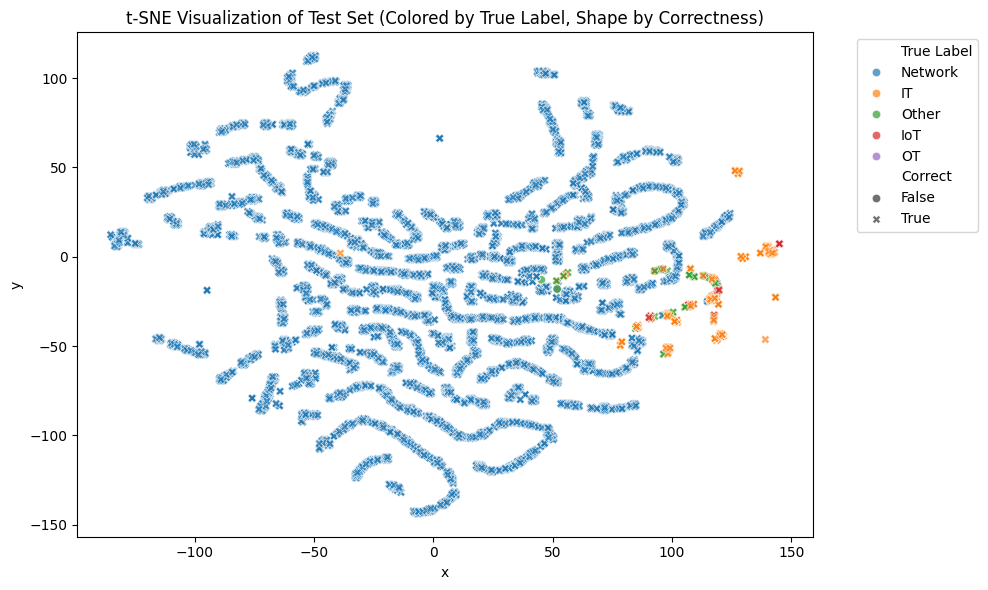

In [7]:
# Visualize test data using t-SNE, coloring by true labels and shaping by prediction correctness
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_test)
tsne_df = pd.DataFrame({
    'x': X_embedded[:, 0],
    'y': X_embedded[:, 1],
    'True Label': label_encoder.inverse_transform(y_test),
    'Predicted Label': label_encoder.inverse_transform(y_pred_rf),
    'Correct': y_test == y_pred_rf
})
# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='True Label', style='Correct', palette='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Test Set (Colored by True Label, Shape by Correctness)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

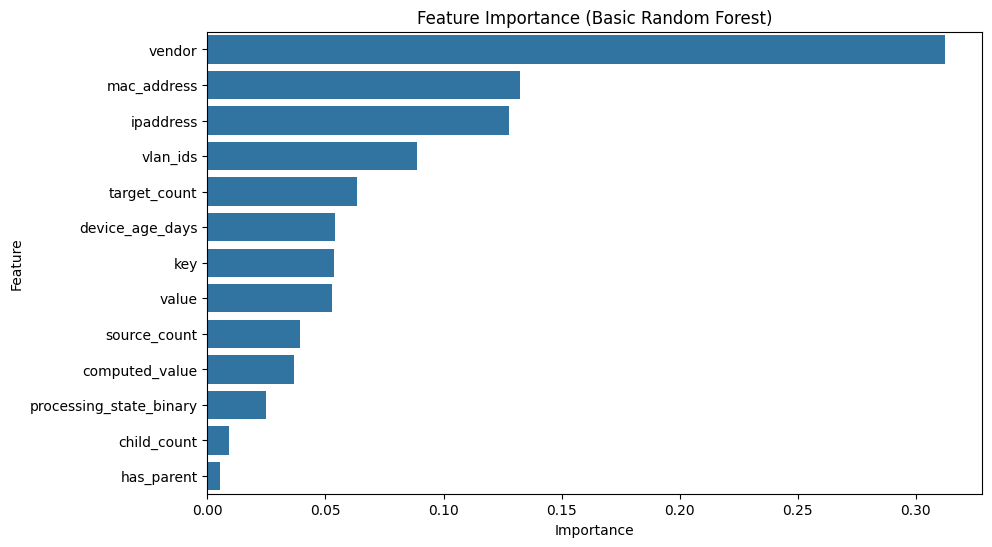

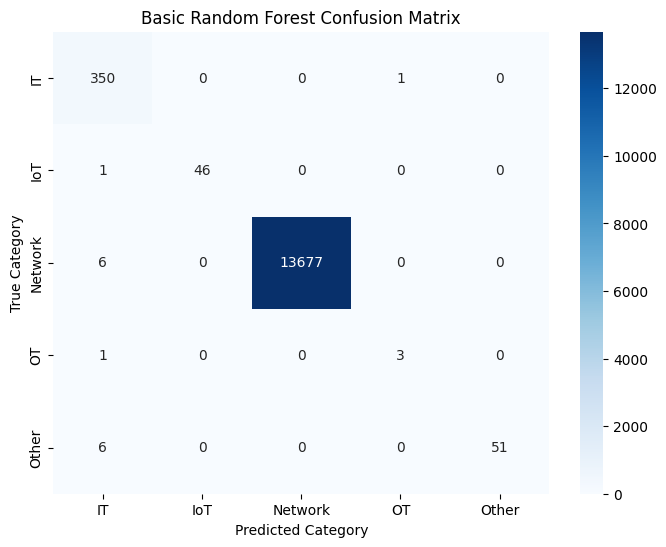

In [8]:
# Feature Importance - Random Forest
feature_importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Basic Random Forest)')
plt.show()
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Basic Random Forest Confusion Matrix")
plt.show()


In [9]:
# Basic Random Forest Backend Performance
pred_foreign = rf.predict(X_foreign)
basic_randomforest = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(basic_randomforest)

              precision    recall  f1-score   support

          IT       0.57      0.97      0.72       270
         IoT       0.55      0.82      0.66        33
     Network       1.00      1.00      1.00     68015
          OT       0.86      0.46      0.60        52
       Other       0.76      0.08      0.15       192

    accuracy                           1.00     68562
   macro avg       0.75      0.67      0.63     68562
weighted avg       1.00      1.00      1.00     68562



#GRID SEARCH RANDOM FOREST

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best Random Forest Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best Cross-Validation Accuracy: 0.9995580477724172

Classification Report (Best Random Forest):
              precision    recall  f1-score   support

          IT       0.98      0.99      0.98       351
         IoT       0.94      0.98      0.96        47
     Network       1.00      1.00      1.00     13683
          OT       0.60      0.75      0.67         4
       Other       1.00      0.93      0.96        57

    accuracy                           1.00     14142
   macro avg       0.90      0.93      0.91     14142
weighted avg       1.00      1.00      1.00     14142



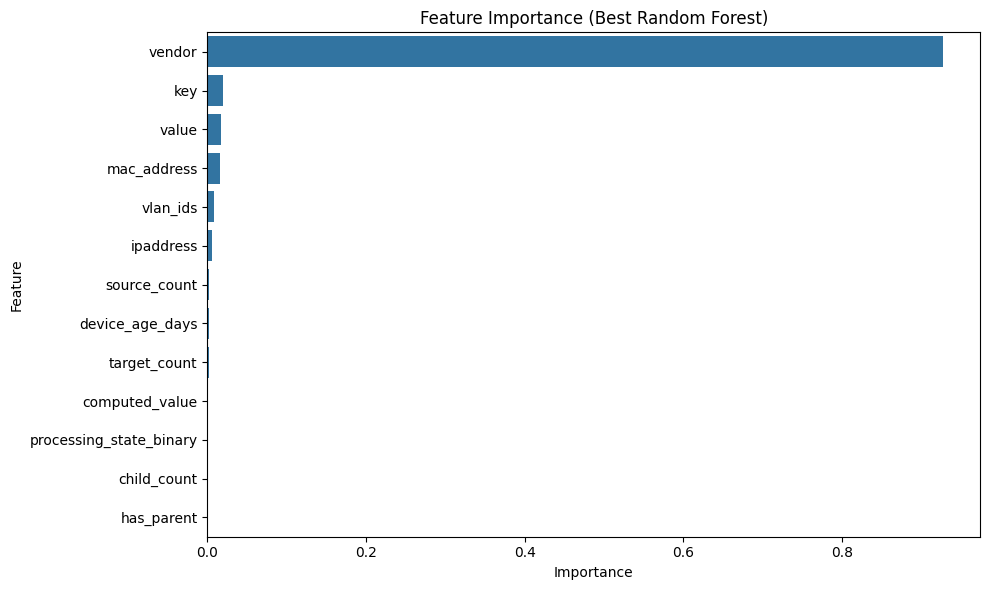

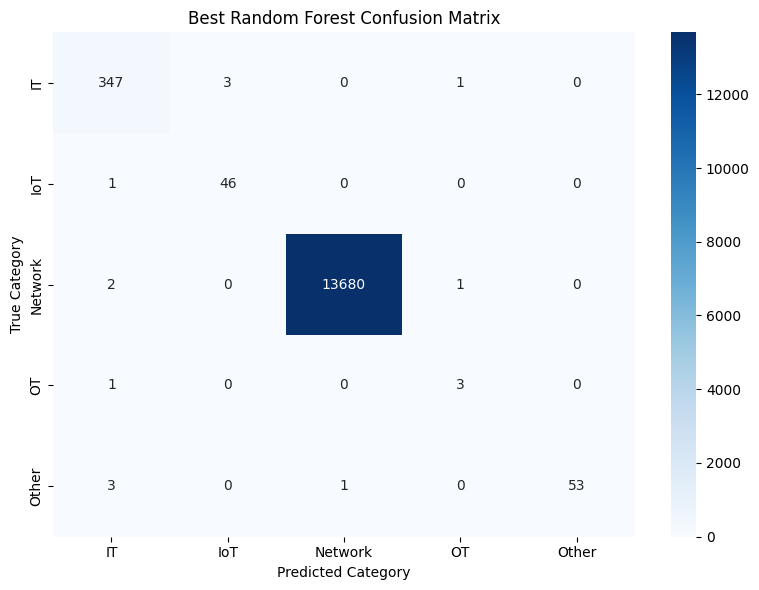

In [10]:
rf = RandomForestClassifier(random_state=42)
randomforest_param_grid = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}
rf_grid_search = GridSearchCV(estimator=rf, param_grid=randomforest_param_grid,
                              cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)
# Output best parameters and score
print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Cross-Validation Accuracy:", rf_grid_search.best_score_)
best_rf = rf_grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
# Classification report
print("\nClassification Report (Best Random Forest):")
print(classification_report(y_test, y_pred_best_rf, target_names=label_encoder.classes_))
# Feature importances
feature_importances_rf = best_rf.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_rf)
plt.title('Feature Importance (Best Random Forest)')
plt.tight_layout()
plt.show()
# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Best Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

In [11]:
# GridSearchCV optimal Random Forest Performance on Backend
pred_foreign = best_rf.predict(X_foreign)
best_randomforest = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(best_randomforest)

              precision    recall  f1-score   support

          IT       0.54      0.73      0.62       270
         IoT       0.01      0.03      0.02        33
     Network       1.00      1.00      1.00     68015
          OT       0.11      0.12      0.11        52
       Other       0.41      0.08      0.14       192

    accuracy                           1.00     68562
   macro avg       0.41      0.39      0.38     68562
weighted avg       1.00      1.00      0.99     68562



#Random Forest with SMOTE

In [12]:
# Definition of smote model and oversampling
smote = SMOTE(sampling_strategy='not majority', random_state=42,k_neighbors=5)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

              precision    recall  f1-score   support

          IT       0.96      1.00      0.98       351
         IoT       1.00      0.98      0.99        47
     Network       1.00      1.00      1.00     13683
          OT       0.75      0.75      0.75         4
       Other       1.00      0.91      0.95        57

    accuracy                           1.00     14142
   macro avg       0.94      0.93      0.93     14142
weighted avg       1.00      1.00      1.00     14142



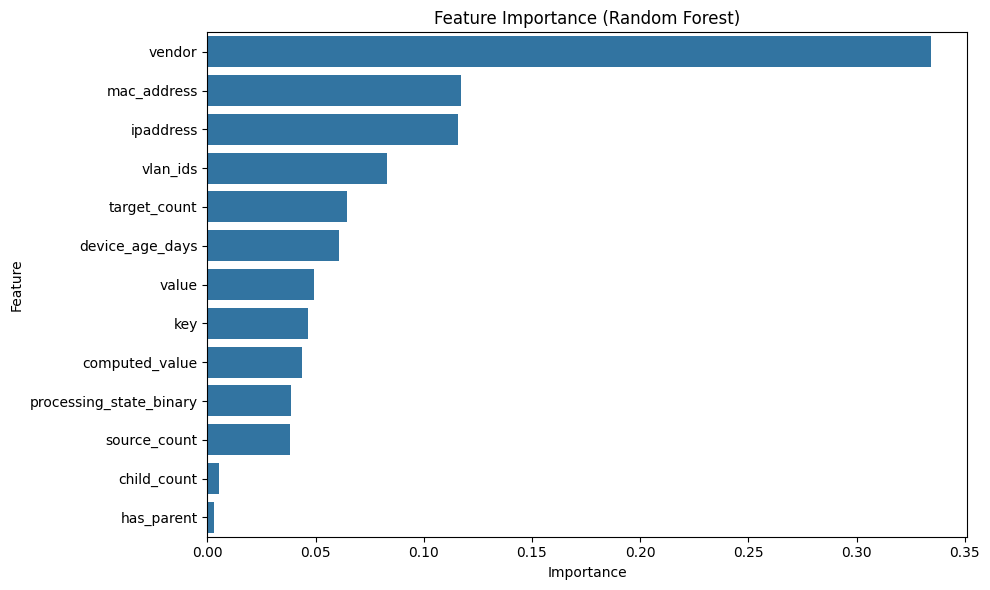

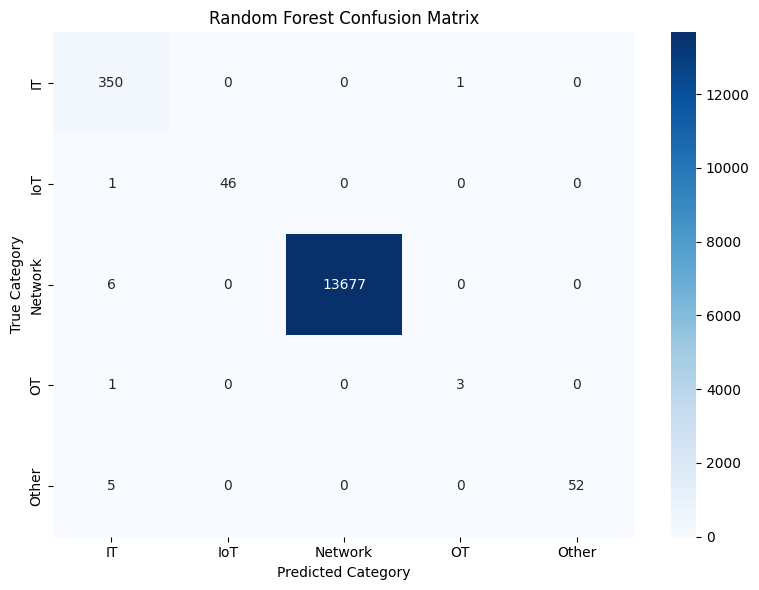

In [13]:
# Random Forest trained on oversampled data
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_oversampled, y_train_oversampled)
y_pred_rf_smote = rf_smote.predict(X_test)
rf_smote_results = classification_report(y_test, y_pred_rf_smote, target_names=label_encoder.classes_)
print(rf_smote_results)
# Feature importance
feature_importances = rf_smote.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()

In [14]:
# SMOTE Random Forest performance on Backend
pred_foreign = rf_smote.predict(X_foreign)
smote_randomforest = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(smote_randomforest)

              precision    recall  f1-score   support

          IT       0.55      0.95      0.70       270
         IoT       0.58      0.88      0.70        33
     Network       1.00      1.00      1.00     68015
          OT       0.35      0.12      0.17        52
       Other       0.68      0.09      0.16       192

    accuracy                           1.00     68562
   macro avg       0.63      0.61      0.55     68562
weighted avg       1.00      1.00      1.00     68562



#RANDOM FOREST TWITH LABEL PROPAGATION APPLIED

In [15]:
def apply_label_propagation(data, kernel='knn', n_neighbors=4, alpha=None, model_type='propagation'):
    """
    Apply semi-supervised learning using label propagation or label spreading to classify unlabeled data.

    Parameters:
    ----------
    data : pandas.DataFrame
        A DataFrame containing both labeled and unlabeled data. It must include a 'category' column,
        where 0 indicates an unlabeled sample and non-zero values indicate labeled classes.

    kernel : str, default='knn'
        The kernel to use in the label propagation algorithm. Options include:
        - 'knn' (k-nearest neighbors)
        - 'rbf' (radial basis function)

    n_neighbors : int, default=4
        Number of neighbors to use for the kernel when `kernel='knn'`.

    alpha : float or None, default=None
        Clamping factor for the LabelSpreading model (ignored if using LabelPropagation). If None,
        defaults to 0.2 when `model_type='spreading'`.

    model_type : str, default='propagation'
        The type of model to use:
        - 'propagation' for LabelPropagation
        - 'spreading' for LabelSpreading

    Returns:
    -------
    pandas.DataFrame
        A copy of the original DataFrame with the 'category' column updated, where previously unlabeled
        (category == 0) samples are now assigned predicted labels.

    Raises:
    ------
    ValueError
        If an invalid `model_type` is provided (must be 'propagation' or 'spreading').

    Notes:
    -----
    This function assumes the features are numeric and suitable for use with scikit-learn's
    LabelPropagation/LabelSpreading models.
    """
    labeled_data = data[data['category'] != 0]
    unlabeled_data = data[data['category'] == 0]
    X_labeled = labeled_data.drop(columns=['category'])
    y_labeled = labeled_data['category']
    X_unlabeled = unlabeled_data.drop(columns=['category'])
    if model_type == 'propagation':
        model = LabelPropagation(kernel=kernel, n_neighbors=n_neighbors)
    elif model_type == 'spreading':
        model = LabelSpreading(kernel=kernel, n_neighbors=n_neighbors, alpha=alpha or 0.2)
    else:
        raise ValueError("Invalid model_type. Choose 'propagation' or 'spreading'.")
    model.fit(X_labeled, y_labeled)
    predicted_labels = model.predict(X_unlabeled)
    updated_data = data.copy()
    updated_data.loc[updated_data['category'] == 0, 'category'] = predicted_labels
    return updated_data

# Creation of Label Propagated Data (Swiss Tools)
swiss_types = my_read_fn("swiss_types")
swiss_asset = my_read_fn("swiss_asset")
swiss_asset = swiss_asset.drop(columns=['name','hostname','active','location_id','assigned_value','estimated_value'])
swiss_asset['asset_type_id'] = swiss_asset['asset_type_id'].fillna(0)
swiss_asset['processing_state_binary'] = swiss_asset['processing_state'].map({
    'QUEUED': 1,
    'PROCESSED': 0
})
swiss_asset = swiss_asset.drop(columns=['processing_state'])
swiss_asset['ipaddress'] = swiss_asset['ipaddress'].apply(network_to_int)
swiss_asset['mac_address'] = swiss_asset['mac_address'].apply(mac_to_int)
swiss_asset['vlan_ids'] = swiss_asset['vlan_ids'].apply(extract_first_vlan)
swiss_asset['date_created'] = pd.to_datetime(swiss_asset['date_created'], utc=True).dt.tz_convert('UTC')
swiss_asset['date_updated'] = pd.to_datetime(swiss_asset['date_updated'], utc=True).dt.tz_convert('UTC')
swiss_asset['device_age_days'] = (swiss_asset['date_updated'] - swiss_asset['date_created']).dt.days
swiss_asset = swiss_asset.drop(columns=['date_created','date_updated','last_reported'])
swiss_types = swiss_types.drop(columns=['name','description','active','parent_asset_type_id','match_slug','icon','date_created','date_updated'])
df_propagated = swiss_asset.merge(swiss_types, how='left', left_on='asset_type_id', right_on='id', suffixes=('', '_type'))
df_propagated.fillna(0, inplace=True)
df_propagated = df_propagated.drop(columns=['id_type'])
df_propagated = df_propagated.merge(swiss_prop, how='left', left_on='id', right_on='asset_id', suffixes=('', '_prop'))
df_propagated['value'] = df_propagated['value'].fillna(0)
source_counts = swiss_relations['source_asset_id'].value_counts().rename('source_count')
target_counts = swiss_relations['target_asset_id'].value_counts().rename('target_count')
df_propagated['source_count'] = df_propagated['id'].map(source_counts).fillna(0).astype(int)
df_propagated['target_count'] = df_propagated['id'].map(target_counts).fillna(0).astype(int)
df_propagated = df_propagated.drop(columns=['asset_id', 'id_prop'], errors='ignore')
child_counts = df_propagated['parent_asset_id'].value_counts().rename('child_count')
df_propagated['child_count'] = df_propagated['id'].map(child_counts).fillna(0).astype(int)
df_propagated['has_parent'] = df_propagated['parent_asset_id'].notna().astype(int)
vendor_counts = df_propagated['vendor'].value_counts()
df_propagated['vendor'] = df_propagated['vendor'].map(vendor_counts)
df_propagated = df_propagated.drop(columns=['parent_asset_id', 'id', 'asset_type_id'], errors='ignore')
df_propagated = df_propagated.fillna(0)
df_propagated['category'] = df_propagated['category'].fillna(0)
data_ = df_propagated

In [16]:
# Apply Label Propagation
result1 = apply_label_propagation(data_, kernel='knn', n_neighbors=4, model_type='propagation')
#result2 = apply_label_propagation(data_, kernel='knn', n_neighbors=6, alpha=0.5, model_type='spreading')
#print(result2)
print(result1)
data_ = result1

         ipaddress   mac_address  computed_value  vlan_ids  \
0        301824712  3.890695e+10               0        45   
1        996114500  2.642007e+14               0      1001   
2       3232261888  3.890695e+10               1      2102   
3       3080766095  2.642007e+14               0      1001   
4        454662365  2.642007e+14               0      1001   
...            ...           ...             ...       ...   
230586  2121152450  2.642007e+14               0      1001   
230587   586807333  3.890695e+10               0        45   
230588  3304807474  2.642007e+14               0      1001   
230589  3300877869  2.642007e+14               0      1001   
230590   917207578  6.160310e+13               0      1007   

        processing_state_binary  device_age_days category  vendor  key  value  \
0                             1                0  Network  159882  0.0    0.0   
1                             1                0  Network  159882  0.0    0.0   
2           

In [17]:
# Encoding propagated 'category'
data_['category_encoded'] = label_encoder.fit_transform(data_['category'])
data_ = data_.drop(columns=['category'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'IT': 0, 'IoT': 1, 'Network': 2, 'OT': 3, 'Other': 4}

In [18]:
data_['id'] = swiss_asset['id']
data = df.drop(columns=['parent_asset_id','asset_type_id']).fillna(0)
data_ = data_[~data_['id'].isin(data['id'])]
#data_filtered
data_ = data_.drop(columns=['id'])

              precision    recall  f1-score   support

          IT       0.97      0.99      0.98       252
         IoT       1.00      0.94      0.97        32
     Network       1.00      1.00      1.00     31966
          OT       0.67      0.50      0.57         4
       Other       0.97      0.94      0.96        34

    accuracy                           1.00     32288
   macro avg       0.92      0.87      0.89     32288
weighted avg       1.00      1.00      1.00     32288



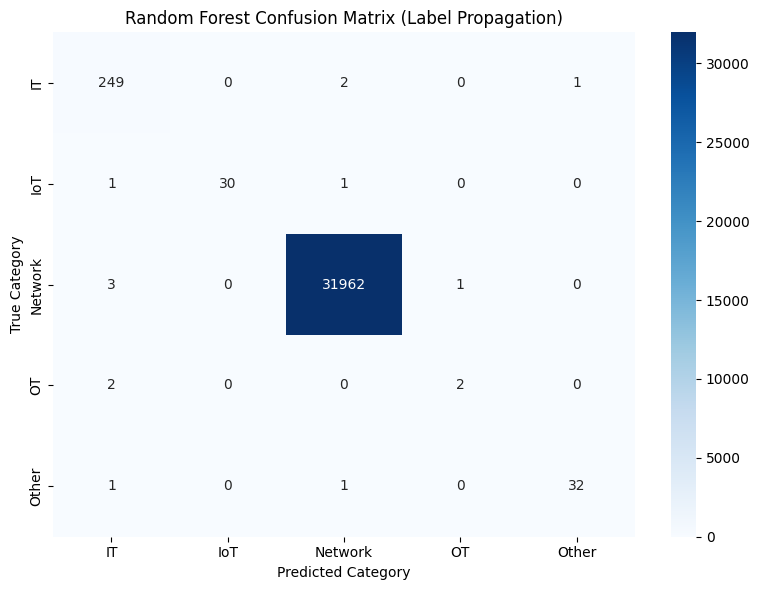

In [19]:
Xl = data_.drop(columns=['category_encoded'])
yl = data_['category_encoded']

# Train-test split
Xl_train, Xl_test, yl_train, yl_test = train_test_split(
    Xl, yl, test_size=0.2, random_state=42, stratify=yl
)

# Train Random Forest
rf_model_propagated = RandomForestClassifier(random_state=42)
rf_model_propagated.fit(Xl_train, yl_train)

# Predict on test set
yl_pred = rf_model_propagated.predict(Xl_test)

# Classification report
print(classification_report(yl_test, yl_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(yl_test, yl_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Random Forest Confusion Matrix (Label Propagation)")
plt.tight_layout()
plt.show()

In [20]:
# Label propagation Random Forest performance on Backend Network:
pred_foreign = rf_model_propagated.predict(X_foreign)
propagated_randomforest = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(propagated_randomforest)

              precision    recall  f1-score   support

          IT       0.55      0.98      0.70       270
         IoT       0.59      0.79      0.68        33
     Network       1.00      1.00      1.00     68015
          OT       0.92      0.42      0.58        52
       Other       0.75      0.02      0.03       192

    accuracy                           1.00     68562
   macro avg       0.76      0.64      0.60     68562
weighted avg       1.00      1.00      1.00     68562



# RANDOM FOREST WITH RANDOM SAMPLING TO MANAGE CLASS IMBALANCE

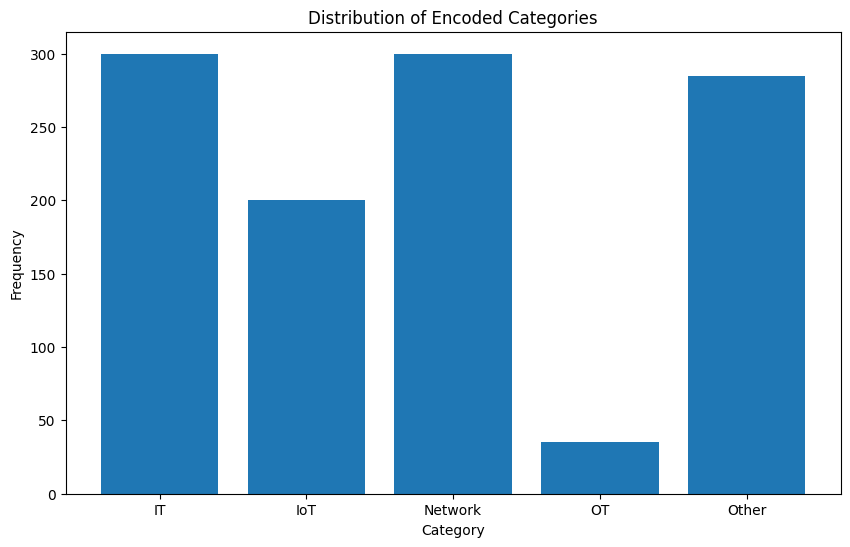

In [21]:
# Sampling and Encoding of sampled data
data = df.drop(columns=['parent_asset_id','id','asset_type_id']).fillna(0)
network_sample = data[data['category'] == 'Network'].sample(n=300, random_state=42)
it_sample = data[data['category'] == 'IT'].sample(n=300, random_state=42)
other_data = data[~data['category'].isin(['Network', 'IT'])]
data_sample = pd.concat([other_data, network_sample, it_sample], ignore_index=True)
label_encoder = LabelEncoder()
data_sample['category_encoded'] = label_encoder.fit_transform(data_sample['category'])
data_sample = data_sample.drop(columns=['category'])
#dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# Sample Data category class distribution
plt.figure(figsize=(10, 6))
plt.hist(data_sample['category_encoded'], bins=range(len(label_encoder.classes_) + 1), align='left', rwidth=0.8)
plt.xticks(range(len(label_encoder.classes_)), label_encoder.classes_)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Distribution of Encoded Categories')
plt.show()


Classification Report:
               precision    recall  f1-score   support

          IT       0.99      0.96      0.97       351
         IoT       0.96      1.00      0.98        47
     Network       1.00      1.00      1.00     13683
          OT       0.80      1.00      0.89         4
       Other       0.80      0.98      0.88        57

    accuracy                           1.00     14142
   macro avg       0.91      0.99      0.94     14142
weighted avg       1.00      1.00      1.00     14142



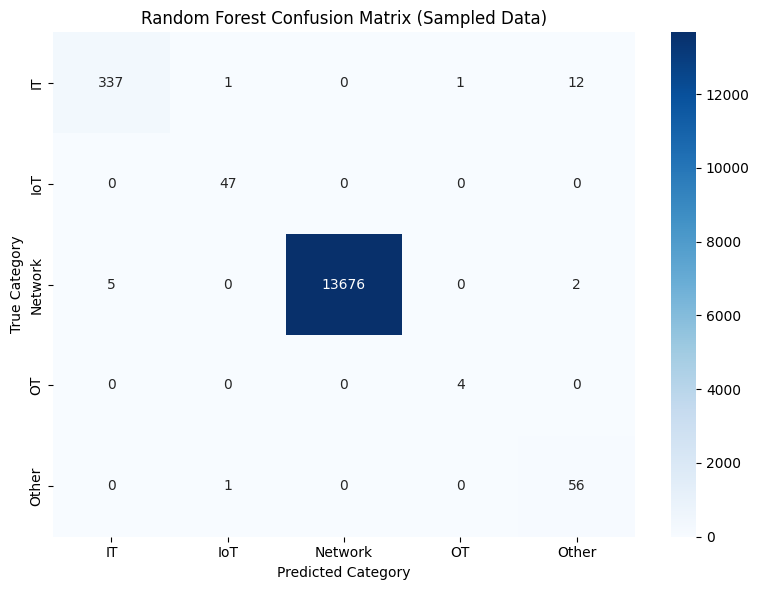

In [22]:
# Random Forest Training on a Sampled Dataset
X_sample = data_sample.drop(columns=['category_encoded'])
y_sample = data_sample['category_encoded']
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)
rf_model_sampled = RandomForestClassifier(random_state=42)
rf_model_sampled.fit(X_train_sample, y_train_sample)
y_pred_sample = rf_model_sampled.predict(X_test)
#Evaluation
print("\nClassification Report:\n", classification_report(
    y_test, y_pred_sample, target_names=label_encoder.classes_)
)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_sample)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Random Forest Confusion Matrix (Sampled Data)")
plt.tight_layout()
plt.show()

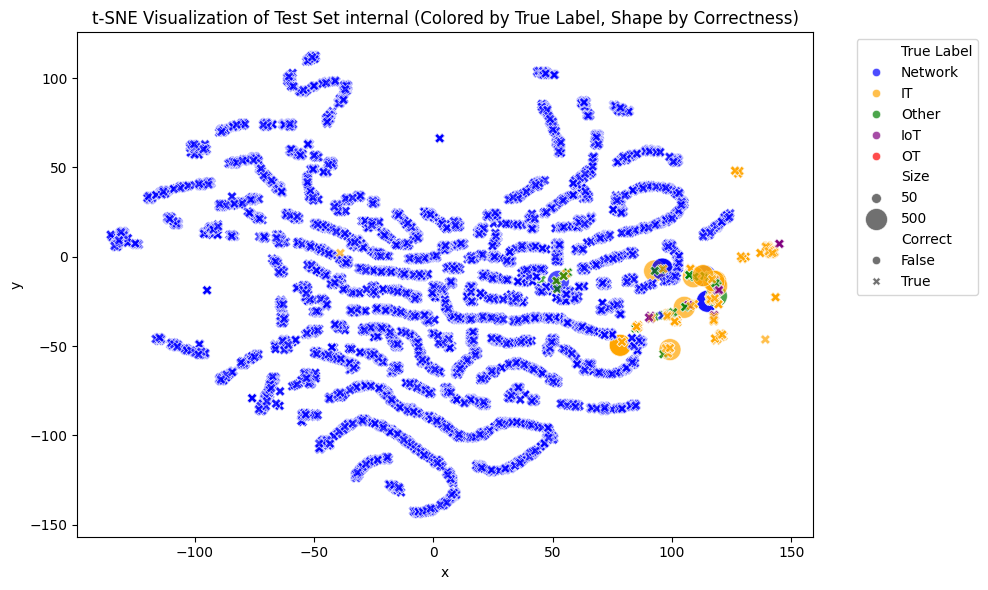

In [23]:
# TSNE Visualization of Swiss Tools Test data
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_test)

tsne_df = pd.DataFrame({
    'x': X_embedded[:, 0],
    'y': X_embedded[:, 1],
    'True Label': label_encoder.inverse_transform(y_test),
    'Predicted Label': label_encoder.inverse_transform(y_pred_sample),
    'Correct': y_test == y_pred_sample
})
tsne_df['Size'] = tsne_df['Correct'].apply(lambda x: 50 if x else 500)
# Plot
custom_palette = {
    'Network': 'blue',
    'IT': 'orange',
    'Other': 'green',
    'IoT': 'purple',
    'OT': 'red'
}
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x='x',
    y='y',
    hue='True Label',
    style='Correct',
    size='Size',   # <- Use this to set point sizes
    sizes=(50, 250),  # (min size, max size) scaling
    palette=custom_palette,
    alpha=0.7
)
plt.title('t-SNE Visualization of Test Set internal (Colored by True Label, Shape by Correctness)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# Sampled Dataset Random Forest performance on Backend
pred_foreign = rf_model_sampled.predict(X_foreign)
sampled_randomforest = classification_report(y_foreign, pred_foreign, target_names=label_encoder.classes_)
print(sampled_randomforest)

              precision    recall  f1-score   support

          IT       0.55      0.81      0.66       270
         IoT       0.57      0.88      0.69        33
     Network       1.00      1.00      1.00     68015
          OT       0.79      0.50      0.61        52
       Other       0.38      0.18      0.24       192

    accuracy                           1.00     68562
   macro avg       0.66      0.67      0.64     68562
weighted avg       1.00      1.00      1.00     68562



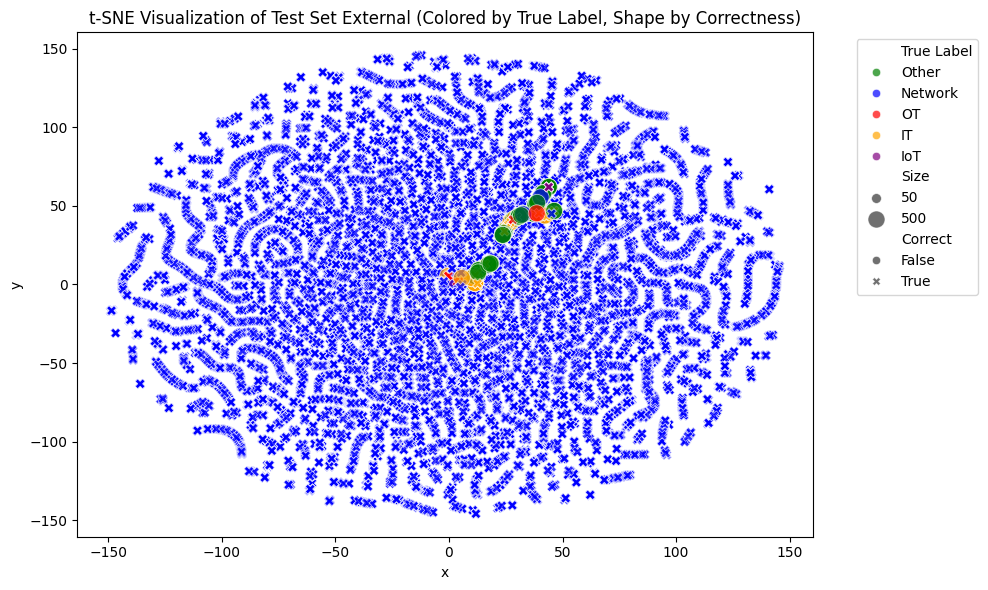

In [25]:
# TSNE Visualization of Backend dataset
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_foreign)

tsne_df = pd.DataFrame({
    'x': X_embedded[:, 0],
    'y': X_embedded[:, 1],
    'True Label': label_encoder.inverse_transform(y_foreign),
    'Predicted Label': label_encoder.inverse_transform(pred_foreign),
    'Correct': y_foreign == pred_foreign
})
tsne_df['Size'] = tsne_df['Correct'].apply(lambda x: 50 if x else 500)
# Plot
custom_palette = {
    'Network': 'blue',
    'IT': 'orange',
    'Other': 'green',
    'IoT': 'purple',
    'OT': 'red'
}
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=tsne_df,
    x='x',
    y='y',
    hue='True Label',
    style='Correct',
    size='Size',   \
    sizes=(50, 150),
    palette=custom_palette,
    alpha=0.7
)
plt.title('t-SNE Visualization of Test Set External (Colored by True Label, Shape by Correctness)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [26]:
# Interactive TSNE, allows to zoom in/out
tsne_df['Correct Label'] = tsne_df['Correct'].map({True: 'Correct', False: 'Incorrect'})
tsne_df['Index'] = tsne_df.index  # Or assign a custom ID column
hover_data=['Index', 'True Label', 'Predicted Label', 'Correct']
fig = px.scatter(
    tsne_df,
    x='x',
    y='y',
    color='True Label',
    symbol='Correct Label',
    size='Size',
    size_max=20,
    color_discrete_map=custom_palette,
    opacity=0.7,
    title='t-SNE Visualization of Test Set External (Interactive)'
)
fig.update_layout(
    legend=dict(title='Legend', x=1.05),
    margin=dict(l=40, r=40, t=60, b=40),
)
fig.show()

In [27]:
# Filter misclassified points
misclassified = tsne_df[tsne_df['Correct'] == False]
# Sort by y ascending (bottom) and x descending (right)
bottom_right_misclassified = misclassified.sort_values(by=['y', 'x'], ascending=[True, False])
# Select top 2 (bottom-rightmost misclassified)
bottom_right_2 = bottom_right_misclassified.head(2)
print(bottom_right_2)


               x         y True Label Predicted Label  Correct  Size  \
38556  12.377545  0.678913         IT           Other    False   500   
67777  11.437246  0.933631         IT           Other    False   500   

      Correct Label  Index  
38556     Incorrect  38556  
67777     Incorrect  67777  


In [28]:
X_foreign.loc[7303]

ipaddress                  1.802732e+08
mac_address                3.890695e+10
computed_value             0.000000e+00
vlan_ids                   4.500000e+01
processing_state_binary    0.000000e+00
device_age_days            1.200000e+02
vendor                     4.015900e+04
key                        0.000000e+00
value                      0.000000e+00
source_count               0.000000e+00
target_count               1.000000e+00
child_count                0.000000e+00
has_parent                 1.000000e+00
Name: 7303, dtype: float64

In [29]:
pred_foreign[68149]

2

# Additional tests after receiving data with manually labelled subset

In [30]:
# Get top 150 by computed_value
top_150 = asset.sort_values(by='computed_value', ascending=False).head(150).copy()
# Replace asset_type_id with asset_type_override_id and overwrite if not null
top_150.loc[top_150['asset_type_override_id'].notna(), 'asset_type_id'] = top_150.loc[top_150['asset_type_override_id'].notna(), 'asset_type_override_id']
# Drop asset_type_override_id column
top_150 = top_150.drop(columns=['asset_type_override_id'])
# Exactly same preprocessing done as with earlier datasets
top_150 = top_150.drop(columns=['name', 'hostname', 'active', 'location_id', 'assigned_value', 'estimated_value'])
top_150 = top_150.dropna(subset=['asset_type_id'])
top_150['processing_state_binary'] = top_150['processing_state'].map({
    'QUEUED': 1,
    'PROCESSED': 0
})
top_150 = top_150.drop(columns=['processing_state'])
top_150['ipaddress'] = top_150['ipaddress'].apply(network_to_int)
top_150['mac_address'] = top_150['mac_address'].apply(mac_to_int)
top_150['vlan_ids'] = top_150['vlan_ids'].apply(extract_first_vlan)
top_150['date_created'] = pd.to_datetime(top_150['date_created'], utc=True).dt.tz_convert('UTC')
top_150['date_updated'] = pd.to_datetime(top_150['date_updated'], utc=True).dt.tz_convert('UTC')
top_150['device_age_days'] = (top_150['date_updated'] - top_150['date_created']).dt.days
top_150 = top_150.drop(columns=['date_created', 'date_updated', 'last_reported'])
types = types.dropna(subset=['category'])
types = types.drop(columns=['name', 'description', 'active', 'parent_asset_type_id', 'match_slug', 'icon', 'date_created', 'date_updated'])
prop['key'] = prop['key'].str.replace('^snmp_', '', regex=True)
prop['key'] = prop['key'].str.split('.').apply(lambda x: [int(i) for i in x if i != ''])
prop['key'] = prop['key'].apply(lambda x: int(''.join(map(str, x))))
prop['value'] = prop['value'].map(prop['value'].value_counts())
prop = prop.drop(columns=['date_created', 'date_updated', 'display_name'])
relations = relations.drop(columns=['id', 'date_created', 'date_updated', 'tags'])
relservices = relservices.drop(columns=['date_created', 'date_updated'])
relservicemetric = relservicemetric.drop(columns=['key', 'attributes', 'date_created', 'date_updated'])
d = top_150.merge(types, how='left', left_on='asset_type_id', right_on='id', suffixes=('', '_type'))
d = d.drop(columns=['id_type'])
d = d.merge(prop, how='left', left_on='id', right_on='asset_id', suffixes=('', '_prop'))
d['value'] = d['value'].fillna(0)
source_counts = relations['source_asset_id'].value_counts().rename('source_count')
target_counts = relations['target_asset_id'].value_counts().rename('target_count')
d['source_count'] = d['id'].map(source_counts).fillna(0).astype(int)
d['target_count'] = d['id'].map(target_counts).fillna(0).astype(int)
d = d.drop(columns=['asset_id', 'id_prop'])
child_counts = d['parent_asset_id'].value_counts().rename('child_count')
d['child_count'] = d['id'].map(child_counts).fillna(0).astype(int)
d['has_parent'] = d['parent_asset_id'].notna().astype(int)
vendor_counts = d['vendor'].value_counts()
d['vendor'] = d['vendor'].map(vendor_counts)
d['vendor'] = label_encoder.fit_transform(d['vendor'].astype(str))

In [31]:
d['category'].value_counts()

category
IT         39
OT         39
Other      36
Network    31
IoT        25
Name: count, dtype: int64

In [32]:
d = d.drop(columns=['parent_asset_id','id','asset_type_id']).fillna(0)
# Encoding categories into integers
d['category_encoded'] = label_encoder.fit_transform(d['category'])
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'IT': 0, 'IoT': 1, 'Network': 2, 'OT': 3, 'Other': 4}

In [33]:
top_150 = d.sort_values(by='computed_value', ascending=False).head(150)


Classification Report:
               precision    recall  f1-score   support

          IT       1.00      0.90      0.95        20
         IoT       1.00      1.00      1.00        12
     Network       1.00      1.00      1.00        16
          OT       0.90      1.00      0.95        19
       Other       0.94      0.94      0.94        18

    accuracy                           0.96        85
   macro avg       0.97      0.97      0.97        85
weighted avg       0.97      0.96      0.96        85



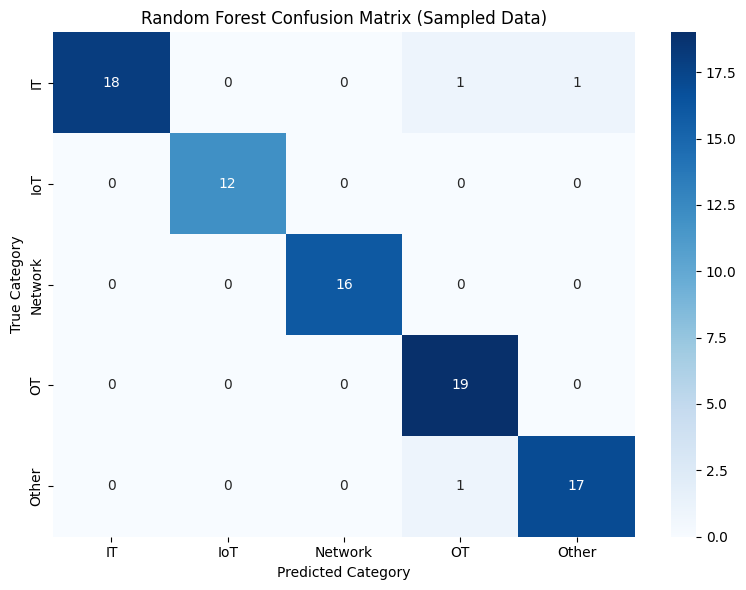

In [34]:
# Basic Random Forest model trained on just manually labeled data in 50/50 train-test split ratio
d = d.drop(columns=['category'])
X = d.drop(columns=['category_encoded'])
y = d['category_encoded']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_, y_train_)
y_pred_sample = rf_model.predict(X_test_)
# Classification report
print("\nClassification Report:\n", classification_report(
    y_test_, y_pred_sample, target_names=label_encoder.classes_)
)

# Confusion Matrix
cm = confusion_matrix(y_test_, y_pred_sample)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Category")
plt.ylabel("True Category")
plt.title("Random Forest Confusion Matrix (Sampled Data)")
plt.tight_layout()
plt.show()


# Even a low number of assets gave satisfactory results in prediction